In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Any results you write to the current directory are saved as output.

In [13]:
data =  pd.read_csv('../data/train.csv', nrows = 15_0000)

In [14]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(data)

In [15]:
print('Old size: %d' % len(data))
data = data.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(data))

Old size: 150000
New size: 149999


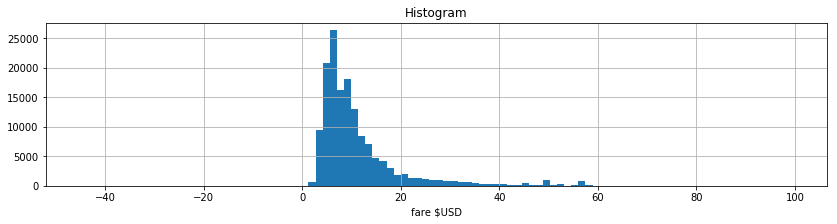

In [16]:
# plot histogram of fare
data[data.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

In [17]:
from datetime import datetime
data['datetime_object'] = [datetime.strptime(date,'%Y-%m-%d %H:%M:%S %Z') for date in data['pickup_datetime']]


In [18]:
#print(data.describe())
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

# add new column to dataframe with distance in miles
data['distance_miles'] = distance(data.pickup_latitude, data.pickup_longitude, \
                                      data.dropoff_latitude, data.dropoff_longitude)

(data.head())

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,datetime_object,distance_miles
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,2009-06-15 17:26:21,0.640487
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,2010-01-05 16:52:16,5.250670
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,2011-08-18 00:35:00,0.863411
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,2012-04-21 04:30:42,1.739386
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,2010-03-09 07:51:00,1.242218


count    143767.000000
mean          2.099860
std           2.330716
min           0.050056
25%           0.804662
50%           1.362978
75%           2.461931
max          64.644331
Name: distance_miles, dtype: float64

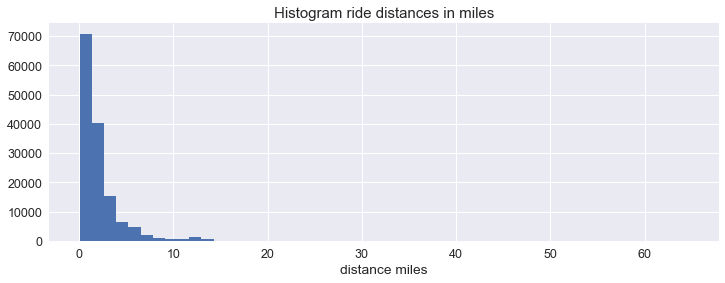

In [26]:
data.distance_miles.hist(bins=50, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')
data.distance_miles.describe()

In [19]:
def late_night (row):
    if (row['hour'] <= 6) or (row['hour'] >= 20):
        return 1
    else:
        return 0


def night (row):
    if ((row['hour'] <= 20) and (row['hour'] >= 16)) and (row['weekday'] < 5):
        return 1
    else:
        return 0
    


#data.distance_miles.hist(bins=50, figsize=(12,4))
#plt.xlabel('distance miles')
#plt.title('Histogram ride distances in miles')
#data.groupby('passenger_count')['distance_miles', 'fare_amount'].mean()
#print("Average $USD/Mile : {:0.2f}".format(data.fare_amount.sum()/data.distance_miles.sum()))
#data['fare_per_mile'] = data.fare_amount / data.distance_miles
data['hour'] = [date.hour for date in data['datetime_object']]
data['year'] = [date.year for date in data['datetime_object']]
data['day'] = [date.day for date in data['datetime_object']]
data['weekday'] = data['datetime_object'].apply(lambda x: x.weekday())
data['night'] = data.apply (lambda x: night(x), axis=1)
data['late_night'] = data.apply (lambda x: late_night(x), axis=1)   
# There is a $1 surcharge from 4pm to 8pm on weekdays, excluding holidays.


In [20]:
print('Old size: %d' % len(data))
data = data[(data.abs_diff_longitude < 3.0) & (data.abs_diff_latitude < 3.0)]
data = data[(data.pickup_longitude >= -74.3) & (data.pickup_longitude <= -72.9)]  # nyc coordinates
data = data[(data.dropoff_longitude >= -74.3) & (data.dropoff_longitude <= -72.9)]
data = data[(data.pickup_latitude >= 40.5) & (data.pickup_latitude <= 41.8)]
data = data[(data.dropoff_latitude >= 40.5) & (data.dropoff_latitude <= 41.8)]
data = data[(data.fare_amount>=2) & (data.fare_amount<=500)]
data = data[(data.passenger_count>0) & (data.passenger_count <=6)]
data = data[(data.distance_miles<=100.0) & (data.distance_miles>0.05)]
nyc = (-74.0063889, 40.7141667)
data['distance_to_center'] = distance(nyc[1], nyc[0],data.dropoff_latitude, data.dropoff_longitude)
data = data[data.distance_to_center<15.0]
print('New size: %d' % len(data))



Old size: 149999
New size: 143767


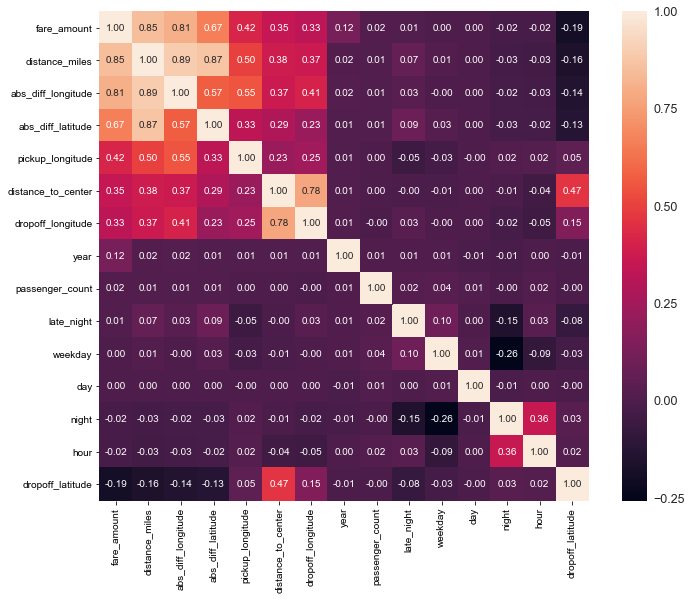

In [21]:

corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))

k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'fare_amount')['fare_amount'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)


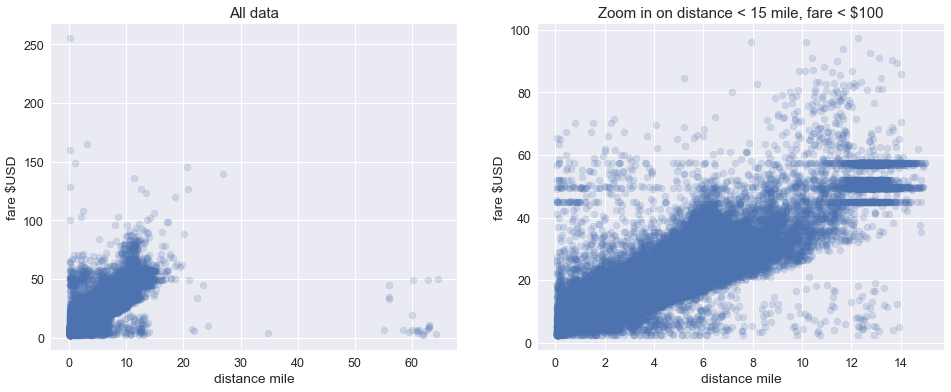

In [30]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(data.distance_miles, data.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance mile')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# zoom in on part of data
idx = (data.distance_miles < 15) & (data.fare_amount < 100)
axs[1].scatter(data[idx].distance_miles, data[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance mile')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 15 mile, fare < $100');

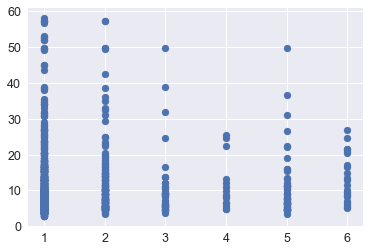

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,datetime_object,distance_miles,hour,year,day,weekday,night,late_night,distance_to_center
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041,2009-06-15 17:26:21,0.640487,17,2009,15,0,1,0,8.630724
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701,2010-01-05 16:52:16,5.250670,16,2010,5,1,1,0,4.897374
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708,2011-08-18 00:35:00,0.863411,0,2011,18,3,0,1,2.636757
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949,2012-04-21 04:30:42,1.739386,4,2012,21,5,0,1,3.132577
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754,2010-03-09 07:51:00,1.242218,7,2010,9,1,0,0,5.468020


In [32]:


#data.year_2015.hist(bins=50, figsize=(12,4))
#plt.xlabel('distance miles')
#plt.title('Histogram ride hour')
plt.scatter(data['passenger_count'][:1000], data['fare_amount'][:1000])
plt.show()
data.head()


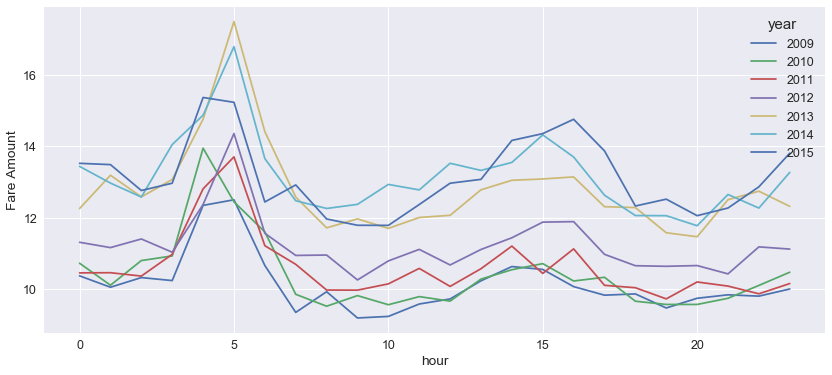

In [36]:
# display pivot table
data.pivot_table('fare_amount', index='hour', columns='year').plot(figsize=(14,6))
plt.ylabel('Fare Amount');